<h1> Nooks Challenge</h1></br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

</br><h2>1. Dataset</h2></br>

### 1.1 Loading dataframe

In [2]:
train_df = pd.read_csv('data/train_data.csv')
train_df

,Unnamed: 0,sid,label,transcript,partial_transcripts
0,0,CF8e49eff05aa1505fd419f4b3183e6898,human,"Hey, what's up?","(0): Hey./(0.4): hey, what's/(0.408): Hey, wha..."
1,1,CF78c33ca4e5d8a1fefbbd814b0b77912a,voicemail,"Hi, this is Frank Apple. I'm unable to take yo...","(0): Hi./(0.356): Hi this./(0.367): hi, this i..."
2,2,CF374e99cf5e643b84243a908d45429bf6,voicemail,Your call has been forwarded to an automated v...,(0): You're?/(0.001): Your call./(0.317): Your...
3,3,CF357bb78d1787f6a9e461ab1f229890c8,human,"Good morning. Absolutely, give me one moment.",(0): Good./(0.418): Good morning./(0.42): Good...
4,4,CF000ffa4ef2954b2b22ae5278033b7bb9,human,Hi. This is Bruce Miller.,"(0): I just/(0.155): Hi, this is Chris./(0.283..."
...,...,...,...,...,...
2913,2913,CF0651f63da6f2ea02f18d7cf6c9efafc8,voicemail,Your call has been forwarded to an automatic v...,(0): Your call./(0.364): Your call has./(0.37)...
2914,2914,CFb10e29e754bf876678745028dee8278b,human,Hello. Yes.,(0): Hello./(1.191): Hello./(1.207): Hello./(3...
2915,2915,CF9b1e586eb99588d63b7244f4da31f9ea,voicemail,Your call has been forwarded to an automatic v...,(0): Your call has been./(0.404): Your call ha...
2916,2916,CF5eb6d8cc9cb4b2e482dee49b5501aa3f,human,Valid.,(0): Valid./(0.307): Salak./(0.975): Valid.


### 1.2 Cleaning dataframe

In [3]:
train_df["label"].value_counts(dropna=False)

voicemail    1952
human         966
Name: label, dtype: int64

Convert labels into numbers:

In [4]:
train_df["label"]=train_df["label"].map({"human":1, "voicemail":0})

Verify if there are null values:

In [5]:
train_df.isnull().sum()

Unnamed: 0              0
sid                     0
label                   0
transcript             49
partial_transcripts    50
dtype: int64

In [6]:
train_df = train_df.dropna(subset=["transcript"])

In [7]:
train_df[train_df["transcript"].isnull()]

,Unnamed: 0,sid,label,transcript,partial_transcripts


Verify if there are duplicated rows:

In [8]:
train_df[train_df.duplicated()]

,Unnamed: 0,sid,label,transcript,partial_transcripts


### 1.3 Splitting dataframe

In [9]:
def train_validate_test_split(df, percent=.7, seed=None):
    df = df.reset_index()
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(percent * m)
    
    train_df = df.iloc[perm[:train_end]]
    eval_df = df.iloc[perm[train_end:]]
    return train_df, eval_df

In [10]:
train_df, eval_df = train_validate_test_split(train_df)

### 1.4 Converting dataframes into datasets

In [11]:
train_ds = Dataset.from_pandas(train_df[["transcript", "label"]])
train_ds

Dataset({
    features: ['transcript', 'label', '__index_level_0__'],
    num_rows: 2008
})

In [12]:
eval_ds = Dataset.from_pandas(eval_df[["transcript", "label"]])
eval_ds

Dataset({
    features: ['transcript', 'label', '__index_level_0__'],
    num_rows: 861
})

</br><h2>2. Modeling </h2></br>

In [13]:
model_name = "bert-base-uncased"

### 2.1 Tokenizing

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [15]:
def preprocess_function(examples):
    return tokenizer(examples["transcript"], truncation=True)

In [16]:
tokenized_train = train_ds.map(preprocess_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

In [17]:
tokenized_eval = eval_ds.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

### 2.2 Defining hyperparameters

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [20]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    run_name="nooks",
)

### 2.3 Defining metrics

In [21]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### 2.4 Training

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [23]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: transcript, __index_level_0__. If transcript, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/workspaces/danielp/anaconda3/envs/jupyter/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2008
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 160
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.096684,0.980256,0.969589,0.960993,0.978339
2,No log,0.058389,0.986063,0.978261,0.981818,0.974729
3,No log,0.063329,0.981417,0.971326,0.964413,0.978339
4,No log,0.056201,0.983740,0.974910,0.967972,0.981949
5,No log,0.057630,0.983740,0.974910,0.967972,0.981949


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: transcript, __index_level_0__. If transcript, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 861
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-32
Configuration saved in ./results/checkpoint-32/config.json
Model weights saved in ./results/checkpoint-32/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-32/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-32/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: transcript, __index_level_0__. If transcript, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely igno

TrainOutput(global_step=160, training_loss=0.08944280743598938, metrics={'train_runtime': 145.8582, 'train_samples_per_second': 68.834, 'train_steps_per_second': 1.097, 'total_flos': 271456609147200.0, 'train_loss': 0.08944280743598938, 'epoch': 5.0})

In [48]:
# model = AutoModelForSequenceClassification.from_pretrained("results/checkpoint-160", num_labels=2)
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train,
#     eval_dataset=tokenized_eval,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics
# )
trainer.save_model("results/best_model")

loading configuration file results/checkpoint-160/config.json
Model config BertConfig {
  "_name_or_path": "results/checkpoint-160",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file results/checkpoint-160/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequ

</br><h2>3. Evaluation</h2></br>

In [38]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [39]:
eval_predictions = trainer.predict(tokenized_eval)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: transcript, __index_level_0__. If transcript, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 861
  Batch size = 64


In [40]:
eval_preds = eval_predictions.predictions.argmax(-1)

### 3.1 Recall

In [41]:
recall_score(eval_ds["label"], eval_preds)

0.9819494584837545

### 3.2 Precision

In [42]:
precision_score(eval_ds["label"], eval_preds)

0.9679715302491103

### 3.3 Accuracy

In [43]:
accuracy_score(eval_ds["label"], eval_preds)

0.983739837398374

### 3.4 Classification report

In [44]:
print(classification_report(eval_ds["label"], eval_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       584
           1       0.97      0.98      0.97       277

    accuracy                           0.98       861
   macro avg       0.98      0.98      0.98       861
weighted avg       0.98      0.98      0.98       861



### 3.5 Confussion Matrix

In [45]:
confusion_df = pd.DataFrame(confusion_matrix(eval_ds["label"], eval_preds),
             columns=["Predicted class voicemail", "Predicted class human"],
             index = ["Real class voicemail", "Real class human"])

print(confusion_df)

                      Predicted class voicemail  Predicted class human
Real class voicemail                        575                      9
Real class human                              5                    272


### 3.6 ROC/AUC

In [46]:
fpr, tpr, _ = roc_curve(eval_ds["label"], eval_predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

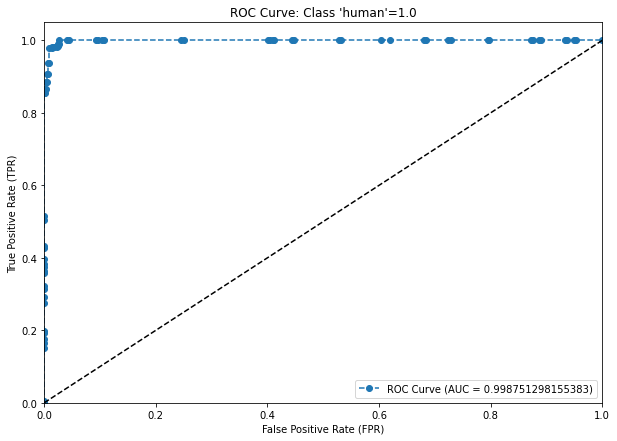

In [47]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr,'o--', label=f"ROC Curve (AUC = {roc_auc})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f"ROC Curve: Class \'human\'=1.0")
plt.legend(loc="lower right")
plt.show()